### Installing MLForecast (if not installed)

In [ ]:
%%capture
!pip install -q mlforecast

In [ ]:
import numpy as np
import pandas as pd

from mlforecast import MLForecast
from mlforecast.utils import generate_daily_series

In [ ]:
# Generating a synthetic timeseries dataset with 50 timeseries and with length between 50 and 500
data = generate_daily_series(50,min_length=50, max_length=500, seed=42)

### Adding a few features we learned to make this into a regression problem

In [ ]:
from mlforecast.lag_transforms import RollingMean, ExpandingMean, Offset
fcst = MLForecast(
    models=[],
    freq='D',
    lags=[1,2,3,4, 7], # Defining the Lags we need to create
    # Defining some transformations we need to do to the lags (offsets)
    lag_transforms={
        1: [ExpandingMean(), RollingMean(window_size=7, min_samples=1), RollingMean(window_size=14)],
    },
)
data = fcst.preprocess(data)
data.head()

,unique_id,ds,y,lag1,lag2,lag3,lag4,lag7,expanding_mean_lag1,rolling_mean_lag1_window_size7_min_samples1,rolling_mean_lag1_window_size14
14,id_00,2000-01-15,0.091118,6.195530,5.086682,4.416597,3.304998,0.115447,3.221919,3.225914,3.221919
15,id_00,2000-01-16,1.377681,0.091118,6.195530,5.086682,4.416597,1.120513,3.013199,3.222439,3.204131
16,id_00,2000-01-17,2.212578,1.377681,0.091118,6.195530,5.086682,2.341632,2.910979,3.259177,3.215019
17,id_00,2000-01-18,3.103971,2.212578,1.377681,0.091118,6.195530,3.304998,2.869897,3.240741,3.229729
18,id_00,2000-01-19,4.283850,3.103971,2.212578,1.377681,0.091118,4.416597,2.882901,3.212023,3.203506


### LightGBM

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
n_val = 15
dates = data['ds'].unique().tolist()
train_dates = dates[:-n_val]
val_dates = dates[-n_val:]

train = data[data['ds'].isin(train_dates)]
val = data[data['ds'].isin(val_dates)]
train_keys = train[["unique_id", 'ds']]
val_keys = val[["unique_id", 'ds']]
train = train.drop(['unique_id', 'ds'], axis=1)
val = val.drop(['unique_id', 'ds'], axis=1)
X_train, Y_train = train.drop(['y'], axis=1), train['y']
X_val, Y_val = val.drop(['y'], axis=1), val['y']

#### Training

For using LightGBM

In [ ]:
params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 4,
    'num_leaves': 15,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'boosting_type': 'gbdt'
}
# For 90% Confidence - 0.1 for lower, 0.5 for median, and 0.9 for upper
quantiles = [.1, .5, .9]

In [ ]:
# Training a model each for the quantiles
quantile_models = {}
for q in quantiles:
    model = LGBMRegressor(alpha=q, **params)
    model = model.fit(X_train, Y_train)
    quantile_models[q] = model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 13090, number of used features: 8
[LightGBM] [Info] Start training from score 0.347853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

## Inference

In [ ]:
# Point Forecast using the 0.5 quantile model
y_pred = quantile_models[0.5].predict(X_val)
y_pred

array([2.25785693, 3.26935478, 4.25110507, 5.22465253, 6.27100003,
       1.24804849, 2.25553351, 3.22641554, 4.25248436, 5.22574216,
       6.23683353, 0.26754469, 1.25264338, 2.27133146, 3.22990561,
       4.24569916, 5.21019256, 6.27039527, 5.2235428 , 6.24038014,
       0.30426623, 1.20149364, 2.26521741, 3.23581594, 4.25144023,
       5.24300242, 6.2205189 , 0.26783323, 1.24999281, 2.23663525,
       3.25484812, 4.25523951, 5.2979896 , 3.04479557, 4.26207912,
       5.20257669, 6.24963648, 0.26166602, 1.24269339, 2.25474285,
       3.24393697, 4.24568378, 5.30294743, 6.23461945, 0.24552137,
       1.24764922, 2.23029538, 3.25491992])

In [ ]:
# Prediction Intervals using the 0.1 and 0.9 quantile models
y_pred_lower = quantile_models[0.1].predict(X_val)
y_pred_upper = quantile_models[0.9].predict(X_val)

#### Plotting

In [ ]:
val = pd.concat([val_keys, val], axis=1)
val['pred'] = y_pred
val['pred_lower'] = y_pred_lower
val['pred_upper'] = y_pred_upper

In [ ]:
import random
# Selecting a few sample ids
sample_uids = random.choices(val_keys['unique_id'].unique(), k=5)

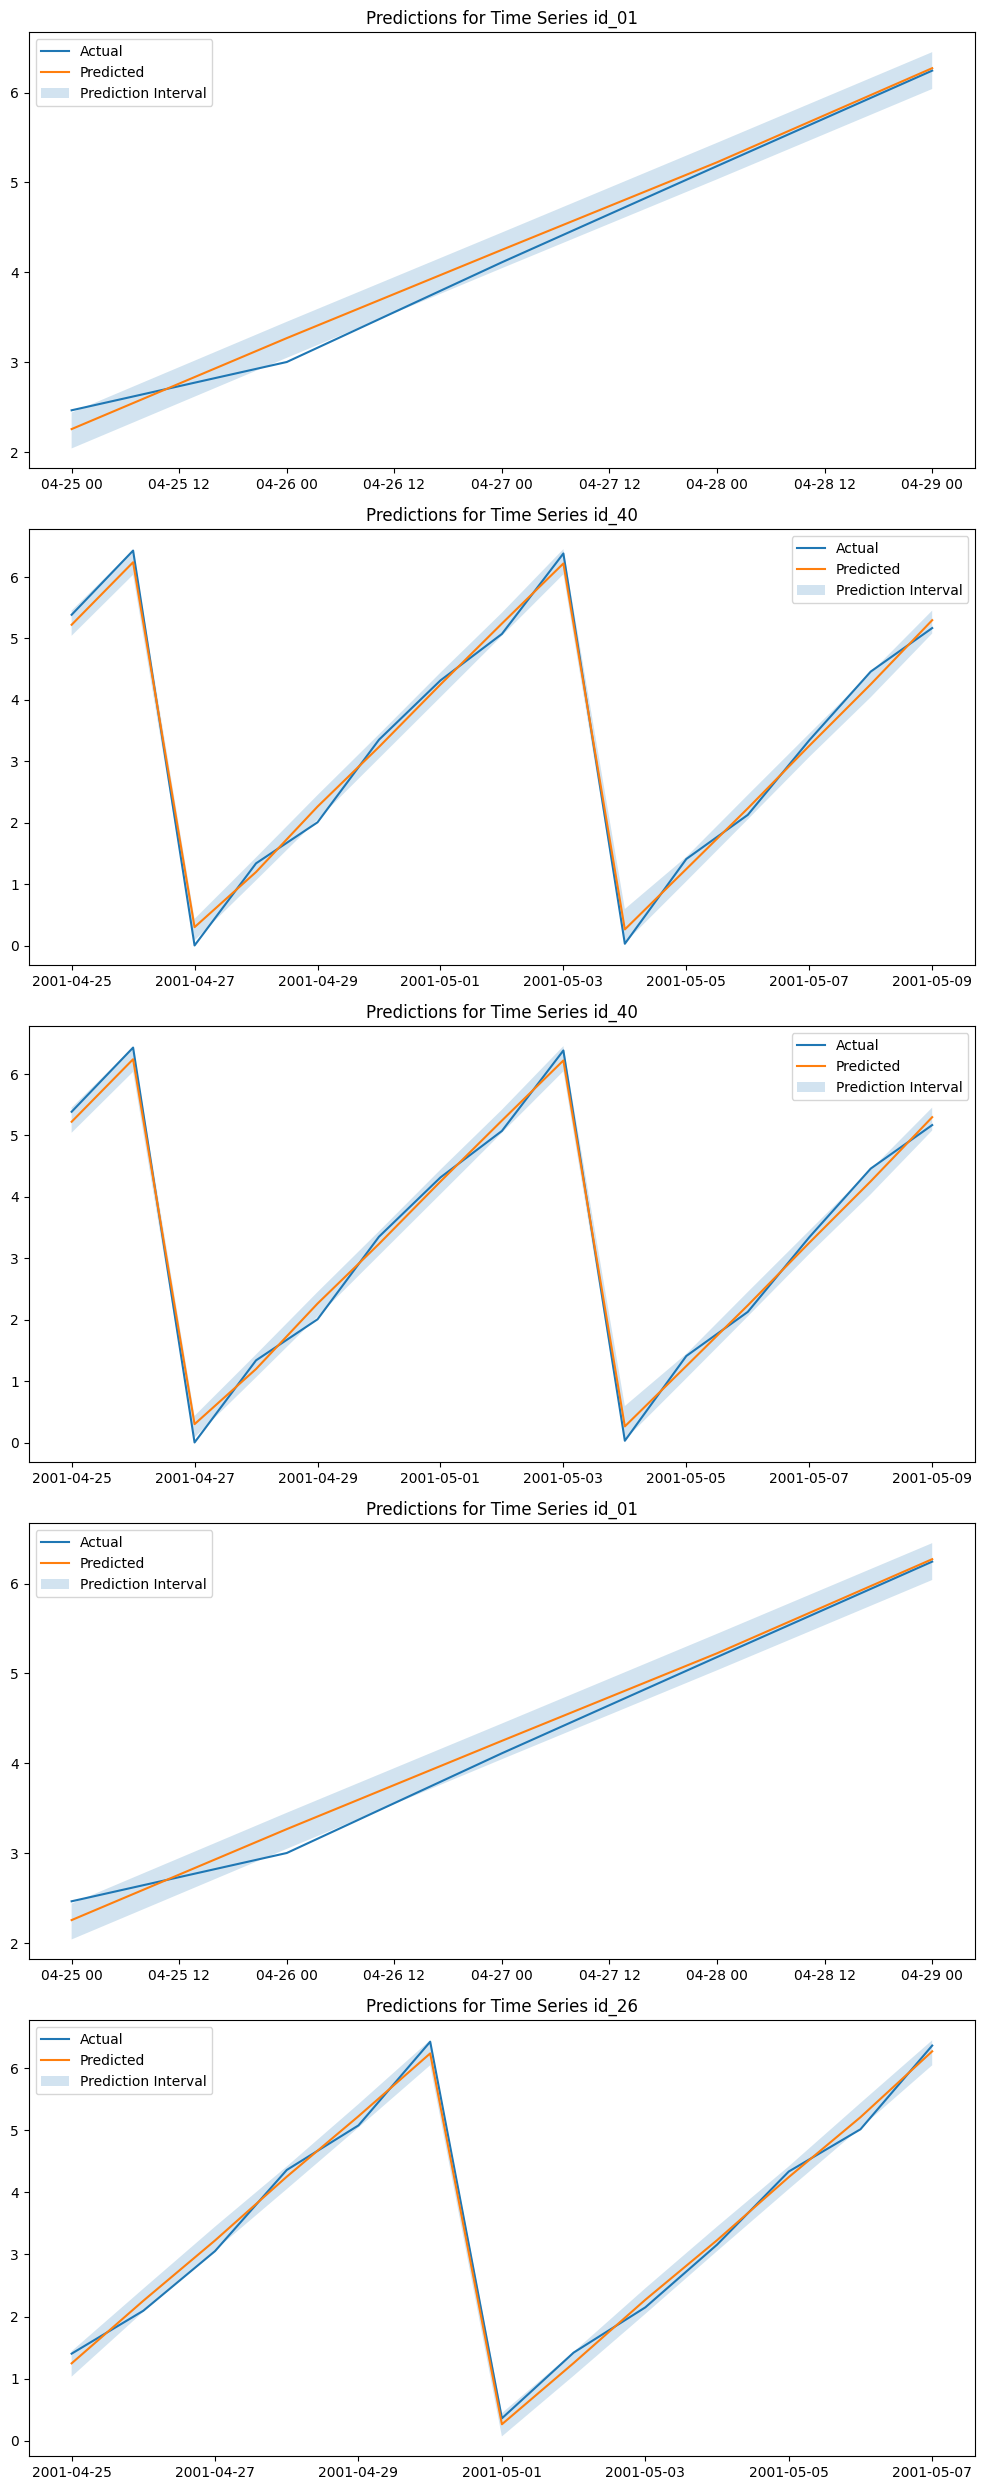

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(val, sample_uids):
  fig, axes = plt.subplots(len(sample_uids), 1, figsize=(10, 5*len(sample_uids)))
  for idx, uid in enumerate(sample_uids):
    val_sample = val[val['unique_id'] == uid]
    axes[idx].plot(val_sample['ds'], val_sample['y'], label='Actual')
    axes[idx].plot(val_sample['ds'], val_sample['pred'], label='Predicted')
    axes[idx].fill_between(val_sample['ds'], val_sample['pred_lower'], val_sample['pred_upper'], alpha=0.2, label='Prediction Interval')
    axes[idx].set_title(f'Predictions for Time Series {uid}')
    axes[idx].legend()
  plt.tight_layout()
  plt.show()

plot_predictions(val, sample_uids)
